# The `word_cloud_store` function

The `word_cloud_store` is a function that creates a word cloud store from a text store.
(By "store" we mean `Mapping` (the fancy way of saying `dict`-like)).
The text store is a mapping from keys to text strings. 
The word cloud store is a mapping from keys to word clouds.

Let's have some fun with that...

## Clouding the files of `guise`

In [80]:
from dol import TextFiles, filt_iter  # don't worry about installing it, guise comes with dol
import guise
import os

guise_rootdir = os.path.dirname(guise.__file__)
guise_files = filt_iter(TextFiles(guise_rootdir), filt=lambda x: x.endswith('.py'))
list(guise_files)


['util.py',
 'tools.py',
 '__init__.py',
 'word_scoring.py',
 'nlp.py',
 'word_clouds.py',
 'examples/__init__.py',
 'examples/energy_startups/__init__.py']

See that `guise_files` is a `Mapping` (that means "dict-like") of text.
We often call that a (text) "store".
The keys are the file names (as seen above with `list(guise_files)`) and the values are 
the contents of the file. See the first 30 characters of `'word_clouds.py'`. 

In [81]:
guise_files['word_clouds.py'][:30]

'"""Word cloud generation with '

Now, if you give a text store (that is, any `Mapping` (e.g. `dict`) of text) to `word_cloud_store`, 
it'll give you back a store with the same keys...

In [82]:
from guise import word_cloud_store

guise_clouds = word_cloud_store(guise_files)
list(guise_clouds)


['util.py',
 'tools.py',
 '__init__.py',
 'word_scoring.py',
 'nlp.py',
 'word_clouds.py',
 'examples/__init__.py',
 'examples/energy_startups/__init__.py']

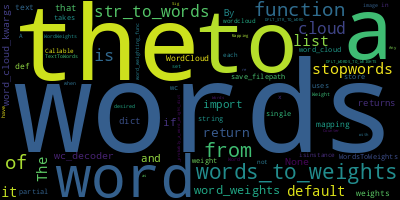

In [83]:
guise_clouds['word_clouds.py']

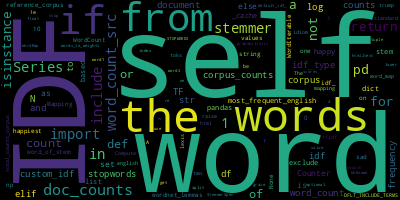

In [39]:
guise_clouds['nlp.py']

## Controlling the words that get into the clouds

Of course, like all good tool, it's simple to use, but you can bend it in many ways, to do many things. 

For example, say you didn't like the clouds above. 
There are too many code bits, underscored words, code-specific names (e.g. "self"). 
They don't really represent what's in the module. 
You'd rather that the word clouds have english words in them. 
Perhaps it's better to not just use the code, but only the doc strings therein...

In [64]:
# Make a function that will extract the docstrings from a Python file
def just_the_docs(python_code, sep='\n'):
    """Extract the docstrings from a Python file.
    All the docstrings: The module's, the classes', the functions'.
    Then concatenate them all into one big string.
    """
    import ast
    module = ast.parse(python_code)
    docstrings = []
    for node in ast.walk(module):
        if isinstance(node, ast.FunctionDef):
            docstrings.append(ast.get_docstring(node))
        elif isinstance(node, ast.ClassDef):
            docstrings.append(ast.get_docstring(node))
    aggregate = sep.join(filter(None, docstrings))
    return aggregate.lower()  # also, let's lower case everything (to count "The" and "the" as the same word)

# Use this little dol tool...
from dol import wrap_kvs
# ... to make a new key-value store that, instead of giving you the contents of the files,
# gives you the docstrings therein. 
guise_doc_files = wrap_kvs(guise_files, value_decoder=just_the_docs)

# Now, instead of using the default str_to_words, we'll only extract sequences of letters as words
# (no numbers or underscores, which is the default). 

guise_doc_clouds = word_cloud_store(guise_doc_files, str_to_words='[a-zA-Z]+')
# Note: this is equivalent to using str_to_words=re.compile('[a-zA-Z]+').findall
#   or str_to_words=lambda x: re.compile('[a-zA-Z]+').findall(x)

And now gaze at the clouds...

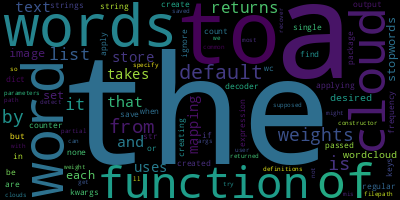

In [65]:
guise_doc_clouds['word_clouds.py']

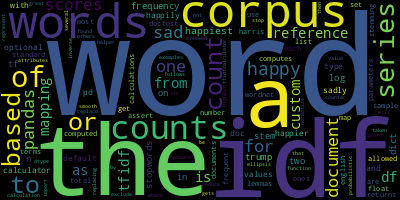

In [66]:
guise_doc_clouds['nlp.py']

## Controlling the weight of the words in the cloud

You probably noticed that a significant amount of visual space is taken by common words. 

Words like "the", "of", "to" etc. don't really convey much information. 
Further, maybe the docs still contain some words you'd like to ignore. 
The NLP concept of "stopwords" takes care of this. 

Finally, to really nail the "this word cloud gives us a snap shot of the what the underlying 
text is about, we probably want to weigh the words, yes, according to how frequently they're used 
in the text, but also lower the weight according to how frequently they're used in 
normal language, to really highlight what is particular about the text. 
This is just the idea of "stop words" made "smooth" (no black/white decision, but a scale).

In [70]:
from guise import STOPWORDS, TFIDFCalculator

# Make a list of stopwords (words to ignore) that includes the default ones plus a few more
my_stopwords = (
    list(STOPWORDS)  # the usual stopwords in English
    + ['dict', 'list', 'pandas', 'series']   # edit this to add or remove more
)

better_guise_doc_clouds = word_cloud_store(
    guise_doc_files, 
    str_to_words='[a-zA-Z]+',
    # remove the stopwords from the word cloud completely
    stopwords=my_stopwords,
    # Use "normal" English word frequencies to weigh the words in such a way that 
    # common words are less important
    words_to_weights=TFIDFCalculator('english')  
)

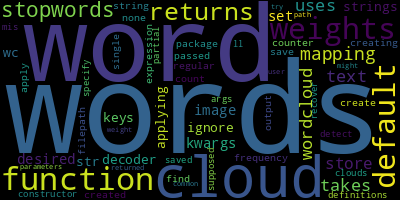

In [71]:
better_guise_doc_clouds['word_clouds.py']

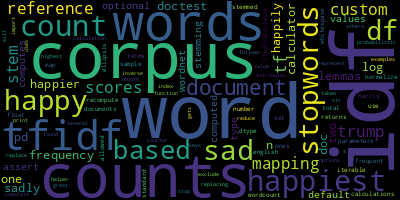

In [73]:
better_guise_doc_clouds['nlp.py']

# The `word_cloud` function

The `word_cloud_store` function uses the `word_cloud` function to do it's job.

And the word `word_cloud` function just adds some useful parameters to the already excellent 
[wordcloud](https://pypi.org/project/wordcloud/) package ([wordcloud documentation](https://amueller.github.io/word_cloud/)). 

The main raison d'être of `word_cloud` over the already existing tools of the `wordcloud` package is 
that I wanted to make easier to make parametrized text-sources-to-word-clouds pipelines. 
Namely, be able to control better the extraction of text, the corresponding words (a.k.a. "tokenization") and weighting of these words.

In [3]:
from guise import word_cloud

In [4]:
list_of_words = ['Rose', 'rose', 'to', 'put', 'rose', 'roes', 'on', 'her', 'rows', 'of', 'roses']
a_word_cloud_obj = word_cloud(list_of_words)

`a_word_cloud_obj` is a `WordCloud` object, from which you can do all kinds of things. 
See [word_cloud's documentation](https://amueller.github.io/word_cloud/) for more information. 
The two main methods we might be interested here are the `to_file(...)` methods and `to_image()` method. 
The later will give you a `PIL.Image` object, which namely, displays in a notebook if it's the last statement in the cell.

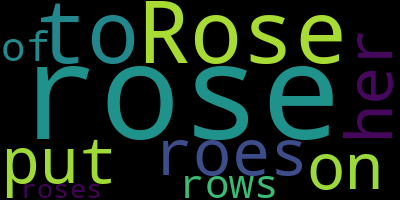

In [5]:
a_word_cloud_obj.to_image()

### Transforming the output

The `wc_decoder` argument lets you transform the output on the fly.
So if you wanted to get a `PIL` image object directly, you could do this:

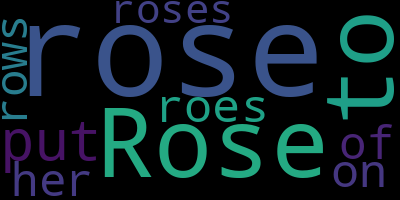

In [6]:
word_cloud(list_of_words, wc_decoder=lambda x: x.to_image())

### Always getting the same output

Notice that the output was different, though the input was the same. 
That's because there's some randomness builtin the process. 
Randomness is often a good thing for creative processes, but if you need consistent outputs, you can fix the `random_state`.

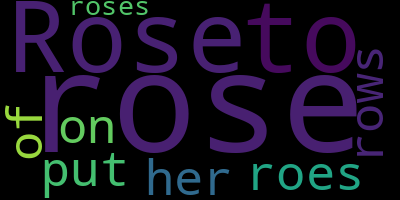

In [7]:
word_cloud(list_of_words, wc_decoder=lambda x: x.to_image(), random_state=42)

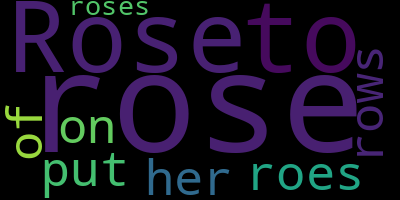

In [8]:
word_cloud(list_of_words, wc_decoder=lambda x: x.to_image(), random_state=42)

### Fixing your parameters

Once you know what you want your parameters to be, you can fix them by calling the function without the first `words` input, and you'll get a function (it's called a "partial" function) with those parameters you specified fixed. 

For example, let's make a `word_cloud_image` that has the `wc_decoder` and `random_state` fixed:

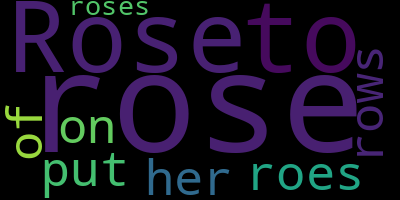

In [9]:
word_cloud_image = word_cloud(wc_decoder=lambda x: x.to_image(), random_state=42)

word_cloud_image(list_of_words)


### Specifying word weights explicitly

Note that the words are more prominent, depending on the number of times it is repeated. 
You can control this "word weight" directly if you specify a `{word: weight, ...}` dict input. 

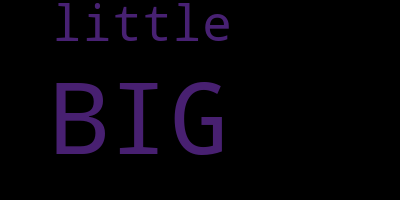

In [10]:
word_cloud_image({'little': 0.2, 'BIG': 20})

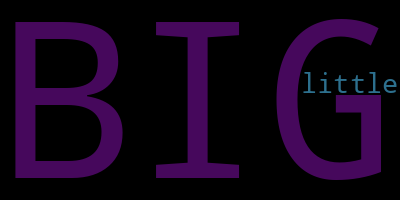

In [11]:
# Q: Why does BIG have a weight 100 times little, yet doesn't appear 100 times bigger?
# A: Because of wordcloud internal defaults meant for general aesthetics. You can control this with extra arguments. For example:
word_cloud({'little': 0.2, 'BIG': 20}, min_font_size=1, max_font_size=1000).to_image()

### Input simple text

If you input just a string, `word_cloud` will both extract the words and (count-)weight them for you:

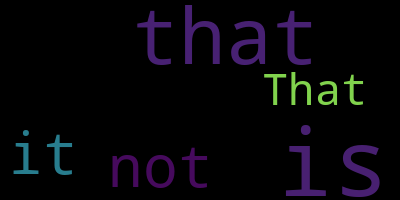

In [18]:
word_cloud_image('That that is is that that is not is not is that it it is.')

### Tokenization (from text to words)

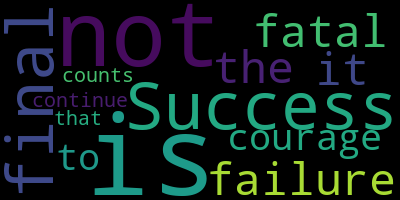

In [19]:
quote_1 = "Success is not-final, failure is not-fatal: it is the courage-to-continue that counts."  # – Winston Churchill
word_cloud_image(quote_1)

Note how "not-final" was split into two words, "not" and "final", and that no punctuation was included. 
`word_cloud` has it's own default way of breaking the text into words (this is called "tokenization").
But you can control this by specifying your own `str_to_words` function. 

Say you want to just split over spaces to get your "words" (really "tokens", because you'll get punctuation, composed words, etc.):

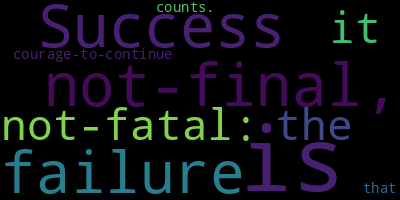

In [22]:
word_cloud_image(quote_1, str_to_words=lambda x: x.split(' '))

If you specify a string as your `str_to_words`, it will be considered as a regular expression that defines what a matching word should be.
Here we define a word to be any uninterrupted sequence of letters, numbers or underscores (that's the `\w` part) or dashes. 

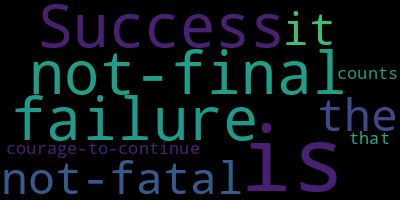

In [23]:
word_cloud_image(quote_1, str_to_words='[\w-]+')

### Control the weighting of the words

Of course, you can always take your text, tokenize it into words, then put those words through a weighting process, then give it to `word_cloud`. But if you want that process to happen automatically when given some text, ou can specify `str_to_words`, as we've seen 
above, for the tokenization, and can also specify the word weighting function through the `words_to_weights` argument.

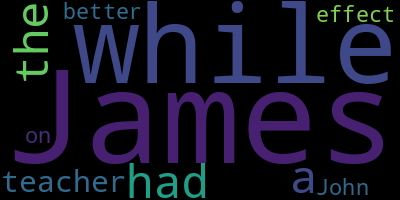

In [13]:
james_had = "James, while John had had 'had,' had had 'had had'; 'had had' had had a better effect on the teacher."

# Let's weight the words by the parity of their length:
word_cloud_image(james_had, words_to_weights=lambda x: 1 + (len(x) % 2))

That `words_to_weights` was a silly one, just for fun. 
Usually, you'll put a bit more work in to get a word weighting function that is appropriate 
for your narrative. 
The `guise` package offers some tools for making these in the `guise.nlp` module. 

For example, we have the `TFIDFCalculator`, with which you can weigh words "up" as 
their word count increases (the `TF` part) but also weight them "down" as those words 
are considered more common in the particular context you're looking at. 
The tool even offers a convenient way to just compare to "general english langauge usage", 
using statistics over 333K+ words of a large English corpus. 

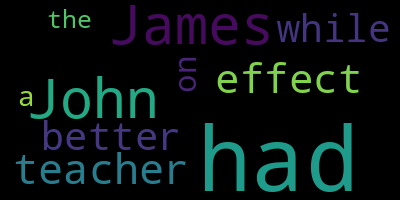

In [14]:
from guise import TFIDFCalculator

words_to_weights = TFIDFCalculator('english')
word_cloud_image(james_had, words_to_weights=words_to_weights)